In [3]:
import numpy as np
import random 
import joblib
import gensim.corpora as corpora

import scipy.special as sp
import matplotlib.pyplot as plt
from gensim.corpora import MmCorpus


import os

from mpmath import *
mp.dps = 20; mp.pretty = True

import time 

# Corpus

In [4]:
corpus = MmCorpus("results/variables/corpus.corp")

# Number of themes

In [5]:
NUMBER_OF_THEMES = 10

# Dictionary of corpus

In [6]:
variables = 'variables'
if not os.path.isdir(variables):
    os.mkdir(variables)

In [7]:
dictionary = corpora.Dictionary(tweets)
dictionary.save('variables/dictionary.dict')
print(dictionary)

Dictionary(7950 unique tokens: ['cada', 'cumplimentar', 'dato', 'debidamente', 'estimar']...)


In [8]:
words = []
for i in dictionary:
    words += [dictionary.get(i)] 
   

# Gibbs initial conditions

In [9]:
# Le ponemos a cada palabra dentro de cada tweet un valor de tema (aleatorio)
from random import randint
def initialConditions(list_tweets, num_themes):
    """
    list_tweets: array that contain every word from the corpus
    num_themes: number of themes to calculate
    
    return: array with tuples (word, theme) from the corpus
    """
    list_a = []
    list_b = []
    tweets_tuple = []
    for arr in list_tweets:
        list_a = arr
        list_b = [randint(1,num_themes) for x in range(len(arr))]
        tweets_tuple.append(list(zip(list_a, list_b)))
        
    return tweets_tuple

tweets_tuple = initialConditions(tweets, NUMBER_OF_THEMES)

In [10]:
def initialTable(words, tweets_tuple, num_themes):
    keys = []
    table = {}
    
    for word in words:
        keys.append(word)

    for k in keys:
        values = [0 for x in range(0,num_themes)]
        table[k] = values
    
    for tweet in tweets_tuple:
        for word in tweet:
            t = word[1]
            w = word[0]
            table[w][t-1] = table[w][t-1] + 1
    
    return table

table_words = initialTable(words, tweets_tuple, NUMBER_OF_THEMES)            
                    

In [11]:
joblib.dump(table_words, "variables/table_words_inicial.pkl")

['variables/table_words_inicial.pkl']

In [12]:
joblib.dump(tweets_tuple, "variables/tweets_tuple_inicial.pkl")

['variables/tweets_tuple_inicial.pkl']

# Load Initial variables

In [13]:
#table_words = joblib.load("variables/table_words.pkl")
#tweets_tuple = joblib.load("variables/tweets_tuple_inicial.pkl")

# Likelihood function

In [14]:
def loglikelihood (words, beta, number_of_themes, table, num_words_theme, constant_value):
    """
    words: array that contains the dictionary
    beta: hyperparameter beta
    number_of_themes: integer that represents the number of themes
    table: dictionary that contains words (keys) and number of times a theme was assigned (values) (array)
    
    
    likehood: likelihood value p(w|z)
    """

    #calculamos term_b
    num_themes = [x for x in range(1, number_of_themes + 1)] # [1,2,3]
    theme_productory = np.array([])
    
    for t in num_themes:         
        dic_values_array = list(table.values()) 
        word_productory = list(zip(*dic_values_array))[t-1]
        
        word_productory = list(map(lambda x : log(gamma(x + beta)), word_productory)) 
                
        term_aux1 = np.sum(word_productory)
        term_aux2 = log(gamma(num_words_theme[t-1] + (len(words) * beta)))
        res = (term_aux1 - term_aux2)
        
        theme_productory = np.append(theme_productory, res) 
        
    
    term_b = np.sum(theme_productory)
    
    likelihood_value = constant_value + term_b
        
    return likelihood_value
    


# Gibbs sampling

In [15]:
def gibbs_sampling(tweets_tuple, words, table, number_of_themes):
    likelihood_values = []
    num_themes = [x for x in range(1, number_of_themes + 1)] 
    #num_word_theme = []
    alpha = (50/number_of_themes)
    beta = 0.1
    num_words_theme = [0 for x in range(0,number_of_themes)] 
    
    # Tweets con maximo likelihood
    tweet_tuple_max = []
    iter_max = 0
    like_max = 0
    
    #Calculamos term_a que es siempre constante por lo que se puede sacar de la iteracion
    term_1 = log(gamma(len(words) * beta))
    term_2 = len(words)*log(gamma(beta))
    term_a = number_of_themes*(term_1-term_2)

    #Creamos la suma de palabras con el mismo tema
    for t in num_themes:
        for word in table:
            num_words_theme[t-1] = num_words_theme[t-1] + table[word][t-1]      
        
    
    for iteration in range(0,1000):
       # start_time = time.time() 
        #np.seterr('raise')
       # print(iteration)
        if(iteration == (1000/4) ):
            print("25% completed")
        if(iteration == (1000/2)):
            print("50% completed")
        if(iteration == (1000*3/4)):
            print("75% completed")
        if(iteration == (999)):
            print("100% completed")        
        
        sum_words_tweet = 0
        tweet_position = 0    
        for tweet in tweets_tuple: 
            word_position = 0 #posicion de la palabra (tweet)
            sum_words_tweet = len(tweet) - 1 

            for word in tweet: #Para cada tupla
                # Pongo a 0 el tema de la palabra seleccionada            
                theme_word = 0
                word_list = list(word)
                theme_word = word_list[1] # me guardo el valor del tema OJO QUE TIENE QUE SER TEMA -1 ya que estamos con listas
                word_list[1] = 0 # Pongo a 0 el tema de la palabra 
                word = tuple(word_list)  
                                
                # Resto -1 en la tabla (fila: palabra, columna:tema que tenía antes de darle valor 0)
                table[word[0]][theme_word-1] = table[word[0]][theme_word-1] - 1 
                
                # Resto -1 a la tabla sumatorio de los temas
                num_words_theme[theme_word-1] = num_words_theme[theme_word-1] - 1 
                
                # Condiciones iniciales para calculo de term_1
                theme_counter = [0 for x in range(0,number_of_themes)] #[0, 0, 0] guardamos el numero de veces que el tema k aparece en el tweet d
                prob_word_theme = [] # Array que contiene la probabilidad de que la palabra pertenezca a tema x [x1, x2, x3...]
                
                # Necesito el numero de veces que el tema t aparece en el tweet (sin contar el tema de la palabra a analizar) 
                word_position2 = 0 # Puede haber 2 palabaras iguales => Contamos posiciones en el array
                for word2 in tweet:
                    if(word_position == word_position2):
                        word_position2 = word_position2 + 1
                        continue
                    else:
                        tem = word2[1]
                        theme_counter[tem-1] = theme_counter[tem-1] + 1
                                
                    word_position2 = word_position2 + 1
                                    
                
                # Para cada uno de los temas que hay 
                for t in num_themes: #recorres 1, 2, 3 (los temas 1 2 3)
                    
                    # Sacamos termino ndk+alpha/sum(ndk)+talpha
                    term_1 = ((theme_counter[t-1] + alpha) / (sum_words_tweet + number_of_themes*alpha))

                    # Sacamos termino vkw+bw/sum(v)+wb
                    term_2 = ((table[word[0]][t-1] + beta) / (num_words_theme[t-1] + (len(words)*beta)))  

                    # Multiplicamos ambos terminos
                    prob_word_theme.append(term_1*term_2)
                    
                    
                #Elegimos aleatoriamente
                new_theme_word = int(random.choices(num_themes, weights=prob_word_theme, k=1)[0])

                #Asignamos el tema a la palabra
                # Pongo a new_word_theme la palabra seleccionada
                word_list = list(word)
                theme_word = new_theme_word # me guardo el valor del tema OJO QUE TIENE QUE SER TEMA -1 ya que estamos con listas
                word_list[1] = new_theme_word # Pongo a new_theme_word el tema de la palabra 
                word = tuple(word_list)  

                tweets_tuple[tweet_position][word_position] = word  
                                
                #Actualizamos tabla
                table[word[0]][theme_word-1] = table[word[0]][theme_word-1] + 1
                                                                                   
                                                                                  
                #Actualizamos el array con suma de temas
                num_words_theme[theme_word-1] = num_words_theme[theme_word-1] + 1 
                                                                                   
                                                                                   
                # Nos vamos a la siguiente palabra
                word_position = word_position + 1
                
        
            tweet_position = tweet_position + 1

        likelihood_value = loglikelihood(words = words, beta = beta, number_of_themes = number_of_themes, table= table, num_words_theme=num_words_theme, constant_value=term_a)
        #Extraemos el corpus con mayor likelihood
        if(iteration > 0):
            if(likelihood_value > likelihood_values[len(likelihood_values)-1]):   
                tweet_tuple_max = tweets_tuple
                iter_max = iteration
        
        likelihood_values.append(likelihood_value)
        #print(likelihood_values)
        
        #end_time = time.time()
        #print("--- %s seconds/ALEJANDRO's PC ---" % (end_time - start_time)) 

        
        
        
        
    return tweets_tuple, likelihood_values, iter_max, tweet_tuple_max

In [16]:
tweets_tuple, likelihood_values, iter_max, tweet_tuple_max= gibbs_sampling(tweets_tuple = tweets_tuple, words = words, table = table_words, number_of_themes = NUMBER_OF_THEMES)


25% completed
50% completed
75% completed
100% completed


# Test section

## Likelihood

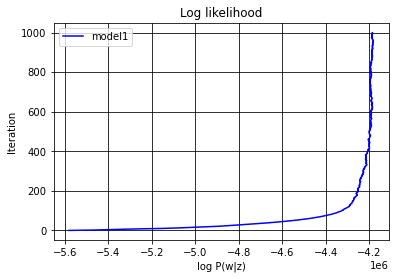

In [17]:
y = range(0, len(likelihood_values))

plt.plot(likelihood_values, y, 'b', label = 'model1')
plt.title("Log likelihood")
plt.xlabel("log P(w|z)")
plt.ylabel("Iteration")
plt.grid(True,color='black')

leg = plt.legend(loc = 2);
plt.show()

# Save variables

In [20]:
joblib.dump(likelihood_values, "variables/likelihood_values.pkl")
joblib.dump(table_words, "variables/table_words_final.pkl")
joblib.dump(tweet_tuple_max, "variables/tweet_tuple_final.pkl")


 

['variables/tweet_tuple_final.pkl']